In [3]:
begin
	using BSON
	using CUDA
	using DrWatson: struct2dict
	using Flux
	using Flux: @functor, chunk
	using Flux.Losses: logitbinarycrossentropy
	using Flux.Data: DataLoader
	using Images
	using Logging: with_logger
	using MLDatasets
	using Parameters: @with_kw
	using ProgressMeter: Progress, next!
	using TensorBoardLogger: TBLogger, tb_overwrite
	using Random
	using Plots
	using Statistics
end

In [4]:
# load MNIST images and return loader
function get_data(batch_size)
	# muss nur beim ersten Laufen und kann dann auskommentiert werden
	MLDatasets.MNIST.download(i_accept_the_terms_of_use=true)
	
    xtrain, ytrain = MLDatasets.MNIST.traindata(Float32)
    xtrain = reshape(xtrain, 28^2, :)
    DataLoader((xtrain, ytrain), batchsize=batch_size, shuffle=true)
end

get_data (generic function with 1 method)

In [5]:
Args

UndefVarError: UndefVarError: Args not defined

In [6]:
begin
	struct Encoder
	    linear
	    μ
	    logσ
	end
	@functor Encoder
	
	Encoder(input_dim::Int, latent_dim::Int, hidden_dim::Int) = Encoder(
    Dense(input_dim, hidden_dim, tanh),   # linear
    Dense(hidden_dim, latent_dim),        # μ
    Dense(hidden_dim, latent_dim),        # logσ
	)

	function (encoder::Encoder)(x)
		h = encoder.linear(x)
		encoder.μ(h), encoder.logσ(h)
	end
	Decoder(input_dim::Int, latent_dim::Int, hidden_dim::Int) = Chain(
		Dense(latent_dim, hidden_dim, tanh),
		Dense(hidden_dim, input_dim)
	)

	function reconstuct(encoder, decoder, x, device)
		μ, logσ = encoder(x)
		z = μ + device(randn(Float32, size(logσ))) .* exp.(logσ)
		μ, logσ, decoder(z)
	end

	function model_loss(encoder, decoder, λ, x, device)
		μ, logσ, decoder_z = reconstuct(encoder, decoder, x, device)
		len = size(x)[end]
    	# KL-divergence
    	kl_q_p = 0.5f0 * sum(@. (exp(2f0 * logσ) + μ^2 -1f0 - 2f0 * logσ)) / len
		
    	logp_x_z = -logitbinarycrossentropy(decoder_z, x, agg=sum) / len
    	# regularization
    	reg = λ * sum(x->sum(x.^2), Flux.params(decoder))
		
    	-logp_x_z + kl_q_p + reg
	end

	function convert_to_image(x, y_size)
    	Gray.(permutedims(vcat(reshape.(chunk(x |> cpu, y_size), 28, :)...), (2, 1)))
	end
	
	# arguments for the `train` function 
	@with_kw mutable struct Args
    	η = 1e-3                # learning rate
    	λ = 0.01f0              # regularization paramater
    	batch_size = 128        # batch size
    	sample_size = 10        # sampling size for output    
    	epochs = 20             # number of epochs
    	seed = 0                # random seed
    	cuda = true             # use GPU
    	input_dim = 28^2        # image size
    	latent_dim = 2          # latent dimension
    	hidden_dim = 500        # hidden dimension
    	verbose_freq = 10       # logging for every verbose_freq iterations
    	tblogger = false        # log training with tensorboard
    	save_path = "output"    # results path
	end

end


Args

In [7]:
function train(; kws...)
    # load hyperparamters
    args = Args(; kws...)
    args.seed > 0 && Random.seed!(args.seed)

    # GPU config
    if args.cuda && CUDA.has_cuda()
        device = gpu
        @info "Training on GPU"
    else
        device = cpu
        @info "Training on CPU"
    end

    # load MNIST images
    loader = get_data(args.batch_size)
    
    # initialize encoder and decoder
    encoder = Encoder(args.input_dim, args.latent_dim, args.hidden_dim) |> device
    decoder = Decoder(args.input_dim, args.latent_dim, args.hidden_dim) |> device

    # ADAM optimizer
    opt = ADAM(args.η)
    
    # parameters
    ps = Flux.params(encoder.linear, encoder.μ, encoder.logσ, decoder)

    !ispath(args.save_path) && mkpath(args.save_path)

    # logging by TensorBoard.jl
    if args.tblogger
        tblogger = TBLogger(args.save_path, tb_overwrite)
    end

    # fixed input
    original, _ = first(get_data(args.sample_size^2))
    original = original |> device
    image = convert_to_image(original, args.sample_size)
    image_path = joinpath(args.save_path, "original.png")
    save(image_path, image)

    # training
    train_steps = 0
	epochenLosses = [[]]
    @info "Start Training, total $(args.epochs) epochs"
    for epoch = 1:args.epochs
        @info "Epoch $(epoch)"
        progress = Progress(length(loader))
		losses = []
		
        for (x, _) in loader 
            loss, back = Flux.pullback(ps) do
                model_loss(encoder, decoder, args.λ, x |> device, device)
            end
			push!(losses,loss)
            grad = back(1f0)
            Flux.Optimise.update!(opt, ps, grad)
            # progress meter
            next!(progress; showvalues=[(:loss, loss)]) 

            # logging with TensorBoard
            if args.tblogger && train_steps % args.verbose_freq == 0
                with_logger(tblogger) do
                    @info "train" loss=loss
                end
            end
			
            train_steps += 1
        end
        # save image
        _, _, rec_original = reconstuct(encoder, decoder, original, device)
        rec_original = sigmoid.(rec_original)
        image = convert_to_image(rec_original, args.sample_size)
        image_path = joinpath(args.save_path, "epoch_$(epoch).png")
        save(image_path, image)
        @info "Image saved: $(image_path)"
		push!(epochenLosses,losses)
    end

    # save model
    model_path = joinpath(args.save_path, "model.bson") 
    let encoder = cpu(encoder), decoder = cpu(decoder), args=struct2dict(args)
        BSON.@save model_path encoder decoder args
        @info "Model saved: $(model_path)"
    end
	return epochenLosses
end

train (generic function with 1 method)

In [ ]:
train()

In [ ]:
epochenLosses = train()

In [10]:
mean(epochenLosses[6])

176.95587f0

In [11]:
#loaded_data = BSON.load("output/model.bson", @__MODULE__) #encoder decoder args

In [12]:
#encoder=loaded_data[:encoder]

In [13]:
#decoder=loaded_data[:decoder]

In [14]:
#args=loaded_data[:args]

In [15]:
function plot_result()
    #BSON.@load "output/model.bson" encoder decoder args
    loaded_data = BSON.load("output/model.bson", @__MODULE__) #encoder decoder args
	encoder=loaded_data[:encoder]
	decoder=loaded_data[:decoder]
	args=loaded_data[:args]
    #args = Args(; args...)
    #device = args.cuda && CUDA.has_cuda() ? gpu : cpu
    device =  cpu
    encoder, decoder = encoder |> device, decoder |> device
    # load MNIST images
    loader = get_data(args[:batch_size])

    # clustering in the latent space
    # visualize first two dims
    plt = scatter(palette=:rainbow)
    for (i, (x, y)) in enumerate(loader)
        i < 20 || break
        μ, logσ = encoder(x |> device)
        scatter!(μ[1, :], μ[2, :], 
            markerstrokewidth=0, markeralpha=0.8,
            aspect_ratio=1,
            markercolor=y, label="")
    end
    #savefig(plt, "output/clustering.png")

    z = range(-2.0, stop=2.0, length=11)
    len = Base.length(z)
    z1 = repeat(z, len)
    z2 = sort(z1)
    x = zeros(Float32, args[:latent_dim], len^2) |> device
    x[1, :] = z1
    x[2, :] = z2
    samples = decoder(x)
    samples = sigmoid.(samples)
    image = convert_to_image(samples, len)
    #save("output/manifold.png", image)
	(plt, image)
end


plot_result (generic function with 1 method)

In [16]:
plt, image = plot_result()

(Plot{Plots.GRBackend() n=19}, Gray{Float32}[Gray{Float32}(0.0012150818f0) Gray{Float32}(0.0012213005f0) … Gray{Float32}(0.0013601423f0) Gray{Float32}(0.0013542746f0); Gray{Float32}(0.0012251858f0) Gray{Float32}(0.0012716941f0) … Gray{Float32}(0.0013541618f0) Gray{Float32}(0.0013479122f0); … ; Gray{Float32}(0.0020238776f0) Gray{Float32}(0.0020213453f0) … Gray{Float32}(0.0021353574f0) Gray{Float32}(0.0021568872f0); Gray{Float32}(0.0020204922f0) Gray{Float32}(0.001977106f0) … Gray{Float32}(0.0021595384f0) Gray{Float32}(0.0021310311f0)])

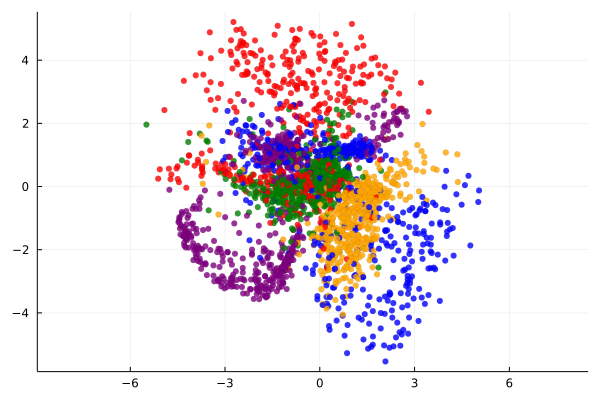

In [17]:
plt

In [18]:
#Rekonstruktion des Bereichs -2:2

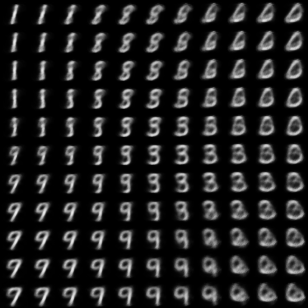

In [19]:
image

In [20]:
begin
    struct Wow
    filename
    end
    
    function Base.show(io::IO, ::MIME"image/png", w::Wow)
    write(io, read(w.filename))
    end
    end

In [21]:
(Wow("output/epoch_1.png"),Wow("output/original.png"))

(Wow("output/epoch_1.png"), Wow("output/original.png"))

In [22]:
(Wow("output/epoch_5.png"),Wow("output/original.png"))

(Wow("output/epoch_5.png"), Wow("output/original.png"))

In [23]:
(Wow("output/epoch_10.png"),Wow("output/original.png"))

(Wow("output/epoch_10.png"), Wow("output/original.png"))

In [24]:
(Wow("output/epoch_20.png"),Wow("output/original.png"))

(Wow("output/epoch_20.png"), Wow("output/original.png"))

In [25]:
#
#Aufgaben
#Speichern sie den Trainingsfehler in jeder der 20 Epochen in einem Feld und stellen sie ihn als Liniendigramm Epoche x Fehler dar.
#Probieren sie vier verschiedene Werte für die Dimension des Latenten Raumes: 2, 5, 10, 100 und stellen sie die vier Kurven der Trainingsfehler über die Epochen in einem Liniendigramm Epoche x Fehler dar. Die Darstellung des Latenten Raumes müssen sie bei Dimensionen ungleich 2 abschalten, ebenso die Darstellung des Bereichs -2:2 x -2:2.
#Wählen 11 Punkte im gleichen Abstand auf einer Diagonale von (-2,...,-2) bis (2,...,2), rekonstruieren sie die Bilder zu den gewählten Punkten und zeigen sie die Bilder an.

In [26]:
# Aufgabe 1

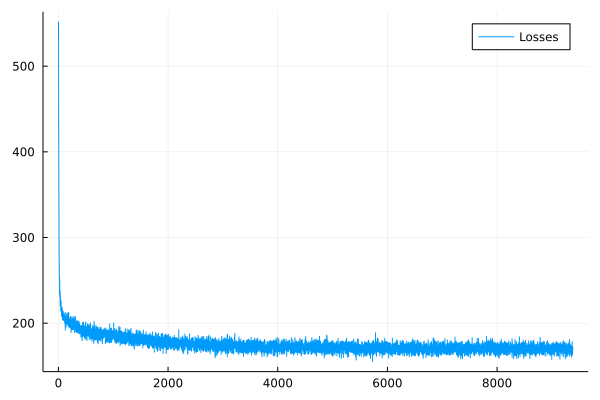

In [27]:
plot(vcat(epochenLosses[2:21]...), label="Losses")

In [28]:
# Aufgabe 2

In [29]:
epochenLosses_5 = train(latent_dim = 5, save_path="output_5")

In [ ]:
epochenLosses_10 = train(latent_dim = 10, save_path="output_10")

In [ ]:
epochenLosses_100 = train(latent_dim = 100, save_path="output_100")

In [ ]:
begin
	plot(vcat(epochenLosses[2:21]...), label="Losses, dim = 2")
	plot!(vcat(epochenLosses[2:21]...), label="Losses, dim = 5")
	plot!(vcat(epochenLosses[2:21]...), label="Losses, dim = 10")
	plot!(vcat(epochenLosses[2:21]...), label="Losses, dim = 100")
end

In [ ]:
##### Aufgabe 3

In [ ]:
loaded_data = BSON.load("output/model.bson", @__MODULE__)

In [ ]:
function plot_diagonal(path="output")
	#BSON.@load "output/model.bson" encoder decoder args
	loaded_data = BSON.load("output/model.bson", @__MODULE__) #encoder decoder args
	encoder=loaded_data[:encoder]
	decoder=loaded_data[:decoder]
	args=loaded_data[:args]
	#args = Args(; args...)
	#device = args.cuda && CUDA.has_cuda() ? gpu : cpu
	device = cpu
	encoder, decoder = encoder |> device, decoder |> device
	
	z = range(-2.0, stop=2.0, length=11)
	len = Base.length(z)
	x = repeat(z, outer = [1, args[:latent_dim]])' |> device
	samples = decoder(x)
	samples = sigmoid.(samples)
	image = convert_to_image(samples, len)
	image
end

In [ ]:
plot_diagonal("output")